In [1]:
# =============================================================================
#  ECUACIÓN DE CALOR 1D CON ALGORITMO GENÉTICO (DEAP) - VERSIÓN CORREGIDA
#  Integrantes: 
#   Luis Pablo López Iracheta 
#   Diego Mares Rodríguez
#   Francisco Marín Castillo
#  Fecha: 22 de oct de 2025
#  
#  du/dt - d2u/dx2 = 0
#  u(0,t) = u(1,t) = 0
#  u(x,0) = 1/5 sin(3πx)
#  0 < t < inf , 0 < x < 1
# =============================================================================

# =============================================================================
#  ECUACIÓN DE CALOR 1D CON ALGORITMO GENÉTICO - VERSIÓN MEJORADA
# =============================================================================

In [2]:
import operator, math, random
import numpy as np
import matplotlib.pyplot as plt
from deap import base, creator, gp, tools, algorithms

In [3]:

# Definimos los operadores primitivos
pset = gp.PrimitiveSet("MAIN", 2)  # Dos variables de entrada (u, t)
# Renombramos los argumentos para mayor claridad
pset.renameArguments(ARG0='u')  # Variable espacial
pset.renameArguments(ARG1='t')  # Variable tiempo

# Agregamos operadores aritméticos básicos
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)

In [4]:
def safe_div(a, b):
    try:
        return a / b if abs(b) > 1e-6 else 1.0
    except:
        return 1.0
pset.addPrimitive(safe_div, 2)

# Funciones matemáticas seguras
def safe_sin(x): return math.sin(x)
def safe_cos(x): return math.cos(x)
def safe_exp(x):
    try: return math.exp(x) if x < 10 else math.exp(10)
    except: return 1.0
def safe_log(x):
    try: return math.log(abs(x)+1e-6)
    except: return 0.0
def safe_neg_exp(x):
    try:
        return math.exp(-abs(x)) if x > -20 else math.exp(20)
    except OverflowError:
        return 1.0

pset.addPrimitive(safe_neg_exp, 1)
pset.addPrimitive(safe_sin, 1)
pset.addPrimitive(safe_cos, 1)
pset.addPrimitive(safe_exp, 1)
pset.addPrimitive(safe_log, 1)

# Constantes aleatorias
pset.addEphemeralConstant("rand101", lambda: random.uniform(-2, 2))

d:\anaconda3\envs\ds_venv\Lib\site-packages\deap\gp.py:257: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "


In [5]:
# Creamos para minimizar la función
try:
    del creator.FitnessMin
    del creator.Individuo
except:
    pass

creator.create("FitnessMin", base.Fitness, weights=(-1.0,)) # Minimizar la función a cero
creator.create("Individuo", gp.PrimitiveTree, fitness=creator.FitnessMin) # Individuo basado en árboles primitivos

Iniciadores

In [6]:
# Configuramos la caja de herramientas
toolbox = base.Toolbox()
toolbox.register("expr_init", gp.genHalfAndHalf, pset=pset, min_=2, max_=4)  # Generador de expresiones
toolbox.register("individuo", tools.initIterate, creator.Individuo, toolbox.expr_init)  # Inicializador de individuos
toolbox.register("population", tools.initRepeat, list, toolbox.individuo)  # Inicializador de población
toolbox.register("compile", gp.compile, pset=pset)  # Compilador de árboles a funciones


In [7]:
# Función objetivo: Evaluar el error en la ecuación del calor
xs = np.linspace(0, 1, 10)  # Puntos en el espacio
ts = np.linspace(0, 0.3, 10)  # Puntos en el tiempo, rango reducido para evitar inestabilidades numéricas

def evaluate_AG(individuo):
    func = toolbox.compile(expr=individuo)
    h = 1e-3
    error_pde = 0.0
    n = 0

    for x in xs:
        for t in ts:
            try:
                u = func(x, t)
                du_dt = (func(x, t+h) - func(x, t-h)) / (2*h)
                d2u_dx2 = (func(x+h, t) - 2*u + func(x-h, t)) / (h**2)
                residuo = du_dt - d2u_dx2
                error_pde += residuo**2
                n += 1
            except (OverflowError, ValueError):
                return (1e6,)

    if n == 0: return (1e6,)

    mse_pde = error_pde / n

    # --- errores físicos principales ---
    mse_pde = error_pde / n
    u_init_error = np.mean([(func(x,0) - 0.2*math.sin(3*math.pi*x))**2 for x in xs])
    border_penalty = sum(abs(func(0,t)) + abs(func(1,t)) for t in ts)

    # --- amplitud: para que no se vuelva plano ---
    amp = np.mean([abs(func(x,0)) for x in xs])
    amp_penalty = 1e-4/(amp + 1e-6)   # favorece amplitud no-cero

    # --- complejidad, funciones no tan largas ---
    size_penalty = len(individuo) * 1e-3

    # --- estructura / forma ---
    expr_str = str(individuo)
    penalty_logx  = 1.0 if "safe_log(x)" in expr_str else 0.0
    penalty_no_exp = 0.5 if "safe_neg_exp" not in expr_str else 0.0

    # --- signo y decaimiento suave ---
    # media espacial en varios tiempos => debe ser positiva, monótona no-creciente y no desaparecer "demasiado" rápido
    times_chk = [0.0, 0.05, 0.1, 0.2, 0.3]
    A = []
    for tt in times_chk:
        A.append(np.mean([func(x, tt) for x in xs]))
    A = np.array(A)

    sign_penalty = 0.1 if A.mean() < 0 else 0.0
    mono_penalty = 0.0
    for i in range(len(A)-1):
        if A[i+1] > A[i] + 1e-6:   # no debe aumentar con t
            mono_penalty += 0.05

    # evita que se “aplane” de golpe: exige que no caiga más rápido que exp(-c_min t)
    c_min = 2.5                        # decaimiento mínimo (suave). Ajustable.
    too_fast = (abs(A[-1]) < abs(A[0]) * math.exp(-c_min * times_chk[-1]))
    speed_penalty = 0.1 if too_fast else 0.0
    
    # Penalizar funciones que no cambian con el tiempo
    t0, t1 = 0.0, 0.2
    u_t0 = np.array([func(x, t0) for x in xs])
    u_t1 = np.array([func(x, t1) for x in xs])
    temporal_diff = np.mean(np.abs(u_t1 - u_t0))
    time_penalty = 0.5 if temporal_diff < 1e-3 else 0

    # Penalizar si u(x,t) no decae con el tiempo
    decay_penalty = 0
    for x in xs:
        u_vals = [func(x, t) for t in ts]
        if any(u_vals[i+1] > u_vals[i] + 1e-3 for i in range(len(u_vals)-1)):
            decay_penalty += 0.2


    # --- mezcla de pesos (ajústalos si quieres) ---
    fitness = (
        1.5 * mse_pde +
        5.0 * u_init_error +
        5.0 * border_penalty +
        0.9 * amp_penalty +
        5.0 * size_penalty +
        1.0 * penalty_logx +
        0.5 * penalty_no_exp +
        1.0 * sign_penalty +
        1.0 * mono_penalty +
        0.9 * speed_penalty +
        1.7 * time_penalty +
        0.8 * decay_penalty
    )


    return (fitness,)

    


In [8]:
toolbox.register("evaluate", evaluate_AG) # Evaluador de individuos en la población
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=1, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=14))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=14))


In [9]:
poblacion = toolbox.population(n=300)
hof = tools.HallOfFame(5)  # guardamos los 5 mejores individuos

stats = tools.Statistics(lambda ind: ind.fitness.values)
#stats.register("avg", np.mean)
#stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

generaciones = 300
p_cruza = 0.4
p_muta = 0.6

for gen in range(generaciones):
    # Evaluamos la población
    invalid_ind = [ind for ind in poblacion if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses): # Asignar fitness
        ind.fitness.values = fit

    # Guardar los mejores (elitismo)
    hof.update(poblacion)
    elites = tools.selBest(poblacion, k=15)  
    offspring = tools.selTournament(poblacion, len(poblacion) - len(elites), tournsize=3)

    # Reproducción (cruce + mutación)
    offspring = algorithms.varAnd(offspring, toolbox, cxpb=p_cruza, mutpb=p_muta)

    # Evaluamos la descendencia
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    # Nueva población = élites + descendencia
    poblacion[:] = elites + offspring

    record = stats.compile(poblacion)
    if gen % 100 == 0:
        print(f"Gen {gen}: {record}")

    # Resultados finales
best = hof[0]
print("Mejores individuos:")
fun_best = toolbox.compile(expr=best)
print(best)
print("Fitness:", best.fitness.values[0])
print(f"u(0, 0.1) = {fun_best(0, 0.1):.4f}")
print(f"u(0.5, 0.1) = {fun_best(0.5, 0.1):.4f}")
print(f"u(1, 0.1) = {fun_best(1, 0.1):.4f}")
print("Longitud del mejor individuo:", len(best))




Gen 0: {'min': 1.5947045507794664, 'max': 3.530778980211585e+28}
Gen 100: {'min': 0.29650216723908124, 'max': 1.4123116010232955e+29}
Gen 200: {'min': 0.29581220880802306, 'max': 2.530108441308416e+20}
Mejores individuos:
safe_exp(add(safe_div(-1.7088397225142313, safe_neg_exp(safe_exp(safe_div(t, 0.1168484628650388)))), -1.2897908539355378))
Fitness: 0.29581220880802306
u(0, 0.1) = 0.0000
u(0.5, 0.1) = 0.0000
u(1, 0.1) = 0.0000
Longitud del mejor individuo: 10


In [10]:
print("u(0.5, t) =", fun_best(0.5, 0.0))

u(0.5, t) = 0.0026454904133209186



GENERANDO GRÁFICAS DE COMPARACIÓN 1D

COMPARACIÓN NUMÉRICA EN PUNTOS CLAVE:
--------------------------------------------------
Posición   Tiempo   Analítica    AG           Error     
--------------------------------------------------
x=0.00    t=0.1    0.000000     0.000000     0.000000  
x=0.25    t=0.1    0.000020     0.000000     0.000020  
x=0.50    t=0.1    -0.000028    0.000000     0.000028  
x=0.75    t=0.1    0.000020     0.000000     0.000020  
x=1.00    t=0.1    0.000000     0.000000     0.000000  
x=0.50    t=0.0    -0.200000    0.002645     0.202645  
x=0.50    t=0.2    -0.000000    0.000000     0.000000  
x=0.50    t=0.3    -0.000000    0.000000     0.000000  
--------------------------------------------------
Error cuadrático medio global: 0.031620


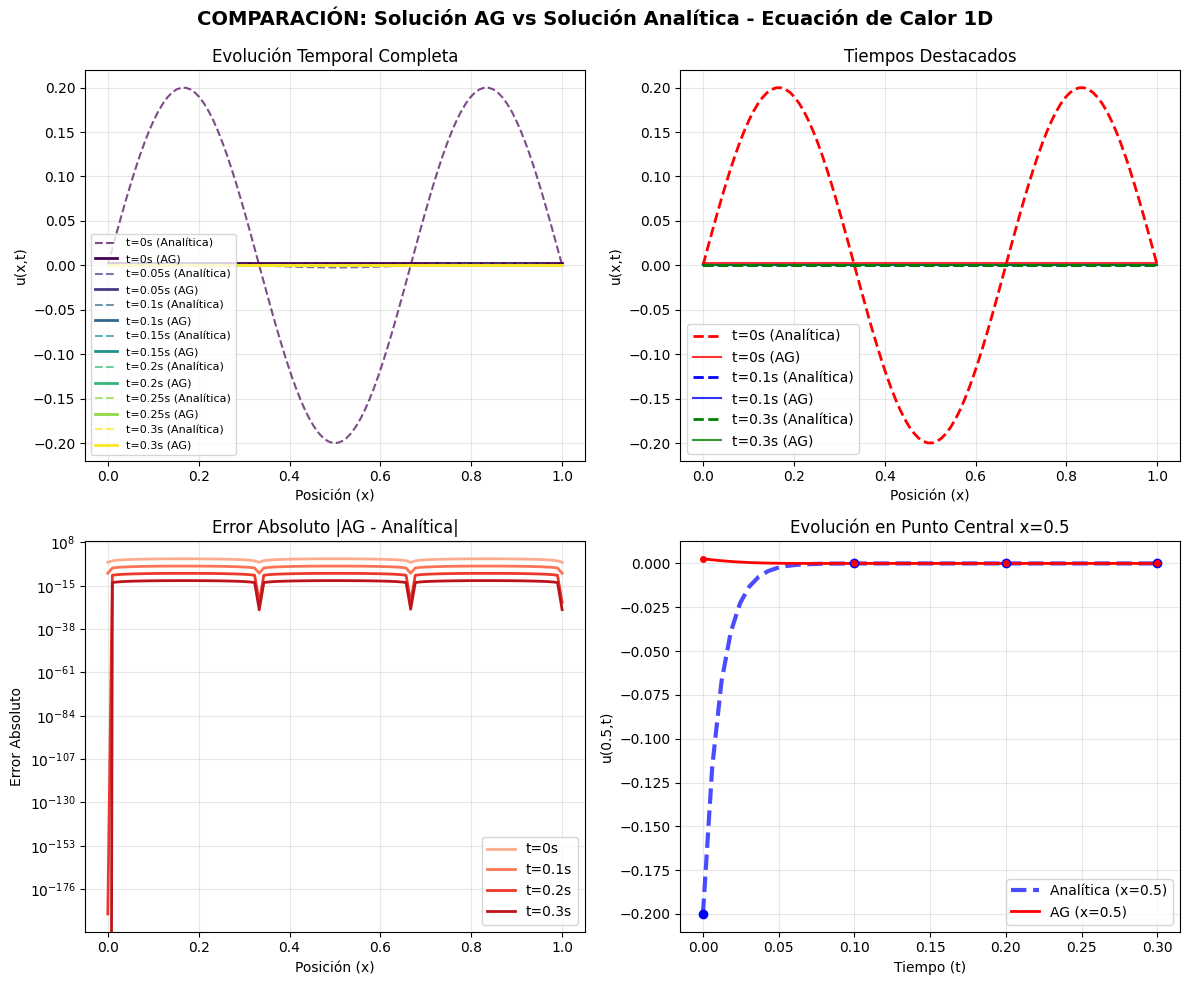


EXPRESIÓN MATEMÁTICA ENCONTRADA POR EL AG:
u(x,t) = safe_exp(add(safe_div(-1.7088397225142313, safe_neg_exp(safe_exp(safe_div(t, 0.1168484628650388)))), -1.2897908539355378))


In [11]:
#==============================================================================
print(50 * "=")
#  GRÁFICAS FINALES
#==============================================================================

import numpy as np
import matplotlib.pyplot as plt

# Función para la solución analítica exacta
def solucion_analitica(x, t):
    return 0.2 * np.sin(3 * np.pi * x) * np.exp(-(3 * np.pi)**2 * t)

# Generar gráficas 1D
print("\n" + "="*60)
print("GENERANDO GRÁFICAS DE COMPARACIÓN 1D")
print("="*60)

# Crear puntos más densos para gráficas suaves
xs_dense = np.linspace(0, 1, 100)
ts_show = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]

# Configurar estilo de gráficas
plt.style.use('default')
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('COMPARACIÓN: Solución AG vs Solución Analítica - Ecuación de Calor 1D', 
             fontsize=14, fontweight='bold')

# 1. Gráfica: Evolución temporal en diferentes tiempos
ax1 = axes[0, 0]
colors = plt.cm.viridis(np.linspace(0, 1, len(ts_show)))

for i, t in enumerate(ts_show):
    # Solución analítica
    u_analitica = [solucion_analitica(x, t) for x in xs_dense]
    # Solución AG
    u_ag = [fun_best(x, t) for x in xs_dense]
    
    ax1.plot(xs_dense, u_analitica, '--', color=colors[i], 
             linewidth=1.5, alpha=0.7, label=f't={t}s (Analítica)')
    ax1.plot(xs_dense, u_ag, '-', color=colors[i], 
             linewidth=2, label=f't={t}s (AG)')

ax1.set_xlabel('Posición (x)')
ax1.set_ylabel('u(x,t)')
ax1.set_title('Evolución Temporal Completa')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=8)

# 2. Gráfica: Comportamiento en tiempos específicos (0, 0.1, 0.3)
ax2 = axes[0, 1]
tiempos_destacados = [0, 0.1, 0.3]
colores_dest = ['red', 'blue', 'green']
estilos_analitica = ['--', '--', '--']
estilos_ag = ['-', '-', '-']

for i, t in enumerate(tiempos_destacados):
    u_analitica = [solucion_analitica(x, t) for x in xs_dense]
    u_ag = [fun_best(x, t) for x in xs_dense]
    
    ax2.plot(xs_dense, u_analitica, estilos_analitica[i], 
             color=colores_dest[i], linewidth=2, 
             label=f't={t}s (Analítica)')
    ax2.plot(xs_dense, u_ag, estilos_ag[i], 
             color=colores_dest[i], linewidth=1.5, alpha=0.8,
             label=f't={t}s (AG)')

ax2.set_xlabel('Posición (x)')
ax2.set_ylabel('u(x,t)')
ax2.set_title('Tiempos Destacados')
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3. Gráfica: Error absoluto en diferentes tiempos
ax3 = axes[1, 0]
tiempos_error = [0, 0.1, 0.2, 0.3]
colores_error = plt.cm.Reds(np.linspace(0.3, 0.8, len(tiempos_error)))

for i, t in enumerate(tiempos_error):
    error_absoluto = []
    for x in xs_dense:
        u_analitica = solucion_analitica(x, t)
        u_ag = fun_best(x, t)
        error_absoluto.append(abs(u_ag - u_analitica))
    
    ax3.plot(xs_dense, error_absoluto, '-', 
             color=colores_error[i], linewidth=2,
             label=f't={t}s')

ax3.set_xlabel('Posición (x)')
ax3.set_ylabel('Error Absoluto')
ax3.set_title('Error Absoluto |AG - Analítica|')
ax3.grid(True, alpha=0.3)
ax3.legend()
ax3.set_yscale('log')  # Escala logarítmica para mejor visualización

# 4. Gráfica: Evolución en punto central x=0.5
ax4 = axes[1, 1]
ts_dense = np.linspace(0, 0.3, 50)
u_analitica_05 = [solucion_analitica(0.5, t) for t in ts_dense]
u_ag_05 = [fun_best(0.5, t) for t in ts_dense]

ax4.plot(ts_dense, u_analitica_05, 'b--', linewidth=3, 
         label='Analítica (x=0.5)', alpha=0.7)
ax4.plot(ts_dense, u_ag_05, 'r-', linewidth=2, 
         label='AG (x=0.5)')

# Agregar algunos puntos de referencia
puntos_ref = [0, 0.1, 0.2, 0.3]
for t in puntos_ref:
    u_a = solucion_analitica(0.5, t)
    u_ag = fun_best(0.5, t)
    ax4.plot(t, u_a, 'bo', markersize=6)
    ax4.plot(t, u_ag, 'ro', markersize=4)

ax4.set_xlabel('Tiempo (t)')
ax4.set_ylabel('u(0.5,t)')
ax4.set_title('Evolución en Punto Central x=0.5')
ax4.grid(True, alpha=0.3)
ax4.legend()

# Ajustar layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)

# Mostrar valores numéricos de comparación
print("\nCOMPARACIÓN NUMÉRICA EN PUNTOS CLAVE:")
print("-" * 50)
print(f"{'Posición':<10} {'Tiempo':<8} {'Analítica':<12} {'AG':<12} {'Error':<10}")
print("-" * 50)

puntos_comparacion = [(0.0, 0.1), (0.25, 0.1), (0.5, 0.1), (0.75, 0.1), (1.0, 0.1),
                      (0.5, 0.0), (0.5, 0.2), (0.5, 0.3)]

for x, t in puntos_comparacion:
    u_analitica = solucion_analitica(x, t)
    u_ag = fun_best(x, t)
    error = abs(u_ag - u_analitica)
    print(f"x={x:<7.2f} t={t:<6.1f} {u_analitica:<12.6f} {u_ag:<12.6f} {error:<10.6f}")

# Calcular error global
error_global = 0
puntos_evaluacion = 20
for i in range(puntos_evaluacion):
    x = i / (puntos_evaluacion - 1)
    for j in range(puntos_evaluacion):
        t = 0.3 * j / (puntos_evaluacion - 1)
        u_analitica = solucion_analitica(x, t)
        u_ag = fun_best(x, t)
        error_global += (u_ag - u_analitica)**2

error_global = np.sqrt(error_global / (puntos_evaluacion**2))
print("-" * 50)
print(f"Error cuadrático medio global: {error_global:.6f}")

plt.show()

# Mostrar expresión del mejor individuo
print("\n" + "="*60)
print("EXPRESIÓN MATEMÁTICA ENCONTRADA POR EL AG:")
print("="*60)
print(f"u(x,t) = {best}")
print("="*60)

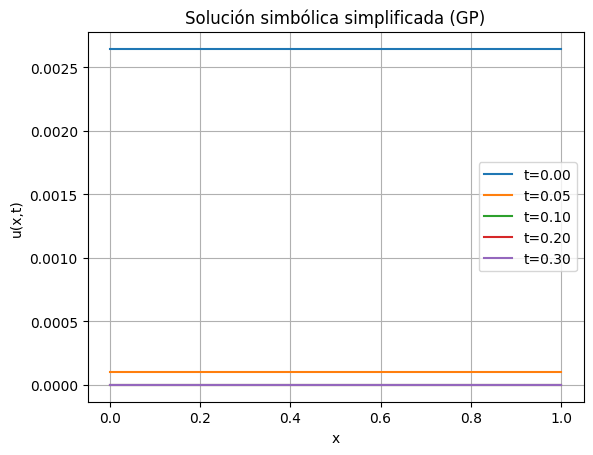

In [12]:
func_best = toolbox.compile(expr=best)
xs_plot = np.linspace(0,1,100)
for t_fixed in [0, 0.05, 0.1, 0.2, 0.3]:
    u_vals = [func_best(x, t_fixed) for x in xs_plot]
    plt.plot(xs_plot, u_vals, label=f"t={t_fixed:.2f}")

plt.title("Solución simbólica simplificada (GP)")
plt.xlabel("x")
plt.ylabel("u(x,t)")
plt.legend()
plt.grid(True)
plt.show()